# PCA and the Partition Function Demo 1

## Preliminary Code

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import gmean

# --- User Inputs ---
n_species = 10
n_levels = 5
temp_options = [100, 200, 300, 400, 500]
temp_k = 300  # Default selection, can be replaced with dropdown
temp_idx = temp_options.index(temp_k)

color_options = ['AvgE', 'Entropy', 'Z', 'F', 'PctInaccess']
color_choice = 'Entropy'  # Default selection, can be replaced with dropdown

THRESH_P = 1e-6
PC_TO_PLOT = [0, 1, 2]  # zero-based in Python
N_LABEL = 5

# --- Constants ---
kB_eVK = 8.617e-5
beta = 1 / (kB_eVK * temp_k)

## 1. Generate Energy Levels

In [ ]:
E = np.random.rand(n_species, n_levels)
level_names = [f"E{j+1}" for j in range(n_levels)]
T_E = pd.DataFrame(E, columns=level_names)
T_E.insert(0, 'Species', np.arange(1, n_species+1))



=== Random energy levels (eV) ===
    Species        E1        E2        E3        E4        E5
0        1  0.421420  0.141614  0.494704  0.815428  0.679609
1        2  0.213593  0.619445  0.585607  0.000879  0.548844
2        3  0.606104  0.060463  0.722520  0.813558  0.882215
3        4  0.183610  0.492768  0.411113  0.897296  0.115699
4        5  0.972023  0.731139  0.800663  0.838560  0.742151
5        6  0.803938  0.700738  0.140626  0.659222  0.895013
6        7  0.225385  0.873298  0.795624  0.765648  0.853979
7        8  0.907269  0.647789  0.337424  0.241514  0.150075
8        9  0.560920  0.566057  0.585437  0.219751  0.869375
9       10  0.187824  0.371718  0.814080  0.186111  0.022949
   Species        E1        E2        E3        E4        E5
0        1  0.421420  0.141614  0.494704  0.815428  0.679609
1        2  0.213593  0.619445  0.585607  0.000879  0.548844
2        3  0.606104  0.060463  0.722520  0.813558  0.882215
3        4  0.183610  0.492768  0.411113  0.897296

## 2. Boltzmann Statistics

In [4]:
Z = np.sum(np.exp(-beta * E), axis=1)
P = np.exp(-beta * E) / Z[:, None]
meanE = np.sum(P * E, axis=1)
S = -kB_eVK * np.sum(P * np.log(np.maximum(P, np.finfo(float).eps)), axis=1)
F = -kB_eVK * temp_k * np.log(Z)
pctNA = 100 * np.sum(P < THRESH_P, axis=1) / n_levels

T_thermo = pd.DataFrame({
    'Species': np.arange(1, n_species+1),
    'AvgE': meanE,
    'Entropy': S,
    'Z': Z,
    'F': F,
    'PctInaccess': pctNA
})
print("\n=== Derived thermodynamic features ===\n", T_thermo)


=== Derived thermodynamic features ===
    Species      AvgE       Entropy             Z         F  PctInaccess
0        1  0.141620  2.177448e-08  4.177417e-03  0.141613         40.0
1        2  0.000936  2.122287e-07  9.668320e-01  0.000872         60.0
2        3  0.060463  1.315627e-12  9.643215e-02  0.060463         80.0
3        4  0.120280  2.128736e-05  1.220651e-02  0.113894         40.0
4        5  0.738981  7.371117e-05  9.050710e-13  0.716868          0.0
5        6  0.140626  4.296624e-12  4.340114e-03  0.140626         80.0
6        7  0.225385  2.194763e-12  1.635122e-04  0.225385         80.0
7        8  0.152788  1.157442e-05  3.101065e-03  0.149316         40.0
8        9  0.219752  5.094185e-09  2.033345e-04  0.219751         40.0
9       10  0.023523  2.217945e-06  4.130378e-01  0.022858         20.0


## 3. Visualize Boltzmann Matrix

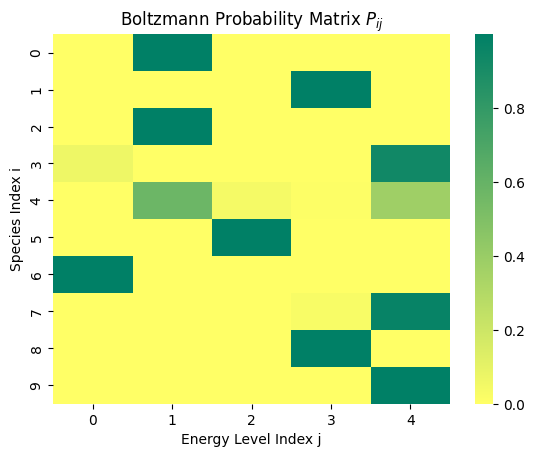

In [5]:
plt.figure()
sns.heatmap(P, cmap='summer_r', square=False, cbar=True)
plt.xlabel("Energy Level Index j")
plt.ylabel("Species Index i")
plt.title("Boltzmann Probability Matrix $P_{ij}$")
plt.show()

## 4. PCA on Probability Matrix

In [6]:
def clr(X):
    X_safe = X + np.finfo(float).eps
    gm = gmean(X_safe, axis=1)
    return np.log(X_safe / gm[:, None])

P_clr = clr(P)
P_scaled = StandardScaler().fit_transform(P_clr)
pca_P = PCA()
score_P = pca_P.fit_transform(P_scaled)
expl_P = pca_P.explained_variance_ratio_ * 100
coeff_P = pca_P.components_.T

## 5. PCA on Thermo Features Matrix

In [7]:
X = StandardScaler().fit_transform(T_thermo[['AvgE', 'Entropy', 'Z', 'F', 'PctInaccess']])
feat_names = ['⟨E⟩','S','Z','F','%NA']
pca_X = PCA()
score_X = pca_X.fit_transform(X)
expl_X = pca_X.explained_variance_ratio_ * 100
coeff_X = pca_X.components_.T

## 6. Plot PCA Results

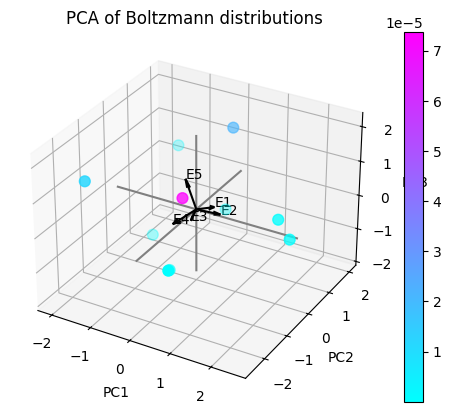

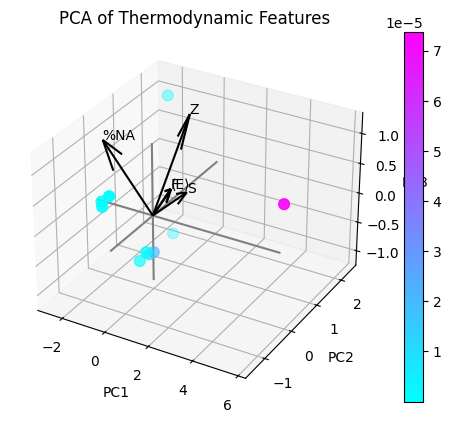

In [8]:
def draw_3d_axes(ax, color='gray'):
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    zlim = ax.get_zlim()
    ax.plot([xlim[0], xlim[1]], [0, 0], [0, 0], color=color)
    ax.plot([0, 0], [ylim[0], ylim[1]], [0, 0], color=color)
    ax.plot([0, 0], [0, 0], [zlim[0], zlim[1]], color=color)

def plot_pca_3d(scores, coeff, labels, color_values, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    p = ax.scatter(scores[:,0], scores[:,1], scores[:,2],
                   c=color_values, cmap='cool', s=60)
    scale = 0.4 * np.max(np.abs(scores))
    for i, label in enumerate(labels):
        ax.quiver(0, 0, 0,
                  coeff[i, 0]*scale,
                  coeff[i, 1]*scale,
                  coeff[i, 2]*scale,
                  color='black', linewidth=1.5)
        ax.text(coeff[i, 0]*scale,
                coeff[i, 1]*scale,
                coeff[i, 2]*scale,
                label, fontsize=10, color='black')
    draw_3d_axes(ax)
    fig.colorbar(p)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')
    ax.set_title(title)
    plt.show()

plot_pca_3d(score_P, coeff_P, level_names, T_thermo[color_choice], "PCA of Boltzmann distributions")
plot_pca_3d(score_X, coeff_X, feat_names, T_thermo[color_choice], "PCA of Thermodynamic Features")

## 7. Various Bar Plots

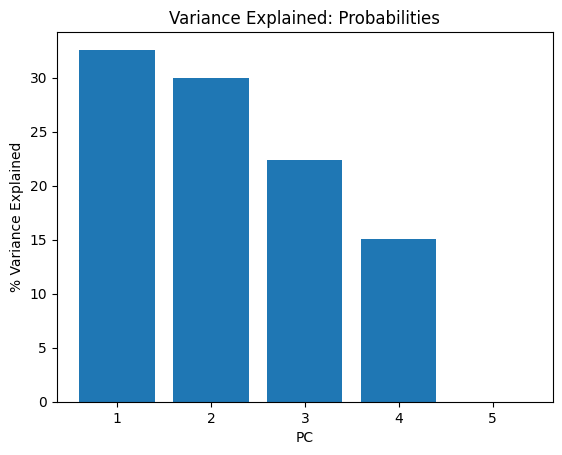

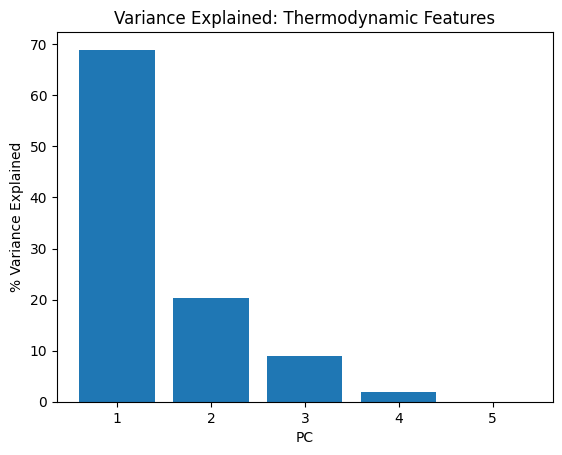

In [11]:
plt.figure()
plt.bar(range(1,6), expl_P[:5])
plt.xlabel('PC')
plt.ylabel('% Variance Explained')
plt.title('Variance Explained: Probabilities')
plt.show()

plt.figure()
plt.bar(range(1,6), expl_X[:5])
plt.xlabel('PC')
plt.ylabel('% Variance Explained')
plt.title('Variance Explained: Thermodynamic Features')
plt.show()

## 8. Correlation Heatmaps

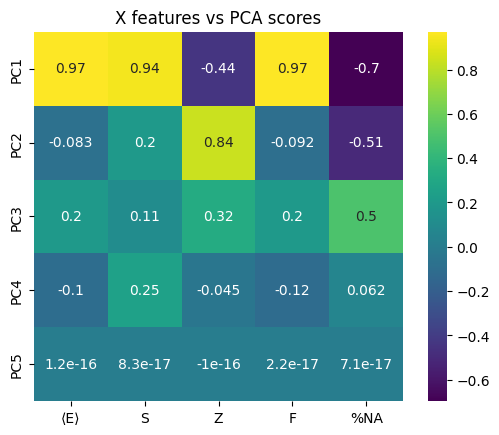

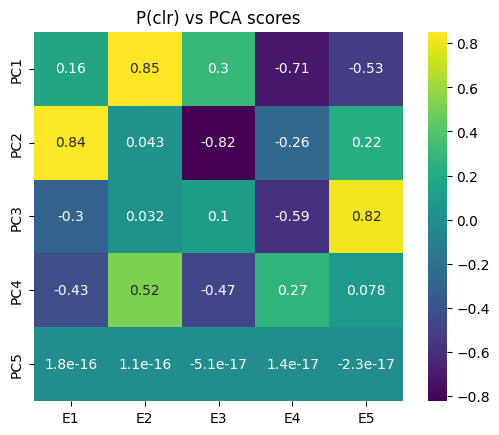

In [13]:
def plot_corr_heatmap(scores, original_data, var_names, title):
    corr = np.corrcoef(scores.T, original_data.T)[:scores.shape[1], scores.shape[1]:]
    plt.figure()
    sns.heatmap(corr, xticklabels=var_names, yticklabels=[f"PC{i+1}" for i in range(scores.shape[1])],
                cmap='viridis', annot=True, square=True)
    plt.title(title)
    plt.show()

plot_corr_heatmap(score_X, X, feat_names, "X features vs PCA scores")
plot_corr_heatmap(score_P, P_clr, level_names, "P(clr) vs PCA scores")

## 9. 'New' Code

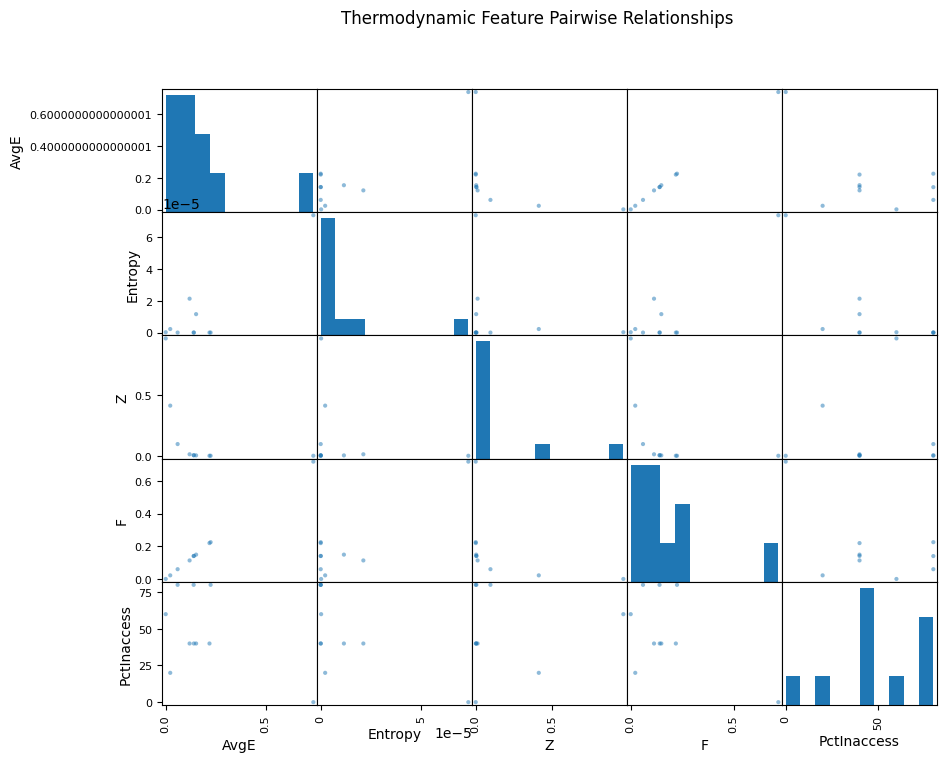

In [14]:
pd.plotting.scatter_matrix(T_thermo[['AvgE', 'Entropy', 'Z', 'F', 'PctInaccess']], figsize=(10,8))
plt.suptitle('Thermodynamic Feature Pairwise Relationships')
plt.show()